## Weight Absorption in Multi-Head Latent Attention (MLA)

### 1. Low-Rank Compression of Keys and Values
In **Multi-Head Latent Attention (MLA)**, the model applies a low-rank compression to the **Keys (K)** and **Values (V)** using a latent vector \( c \).

The projections are defined as:

\[
Q = x W_q
\]

\[
K = c W_{uk}
\]

where:

- \( x \) is the input token representation  
- \( c \) is the latent vector (compressed representation)  
- \( W_q \) is the query projection matrix  
- \( W_{uk} \) is the key projection matrix  

---

### 2. Weight Absorption (Matrix Fusion)

Since both queries and keys participate in the attention dot product, their projection matrices can be **mathematically combined**.

By **pre-multiplying** the projection matrices \( W_q \) and \( W_{uk} \), the key-related weights are *absorbed* into the query projection. This results in a **single effective projection matrix**.

Conceptually:

\[
QK^\top = x W_q (c W_{uk})^\top
\]

\[
= x (W_q W_{uk}^\top) c^\top
\]

Thus, instead of computing two separate matrix multiplications during inference, the model performs **one fused matrix multiplication**.

---

### 3. Optimization Benefits

- **Reduced latency** due to fewer matrix multiplications during inference  
- **Lower computational overhead**, especially for large models and long sequences  
- **Inference-time optimization**, typically applied after training  

---

### 4. PyTorch Implementation Detail (`register_buffer`)

In PyTorch, the absorbed weight matrix (e.g., `absorbed_k`) is stored using:

```python
self.register_buffer("absorbed_k", absorbed_k)
```

The use of `register_buffer` tells PyTorch that:

- `absorbed_k` is part of the model's state
- It will be saved and loaded via `state_dict`
- It is not treated as a trainable parameter
- No gradients are computed for it during backpropagation

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F



In [13]:
class RopelessMLA(nn.Module):
    def __init__(self, d_model, n_heads, kv_latent_dim):  # Fixed: __init__ not _init_
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dh = d_model // n_heads
        self.kv_latent_dim = kv_latent_dim

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_dkv = nn.Linear(d_model, kv_latent_dim, bias=False)
        self.W_uk = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.W_uv = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        self.ln = nn.LayerNorm(kv_latent_dim)  # Fixed: ln not nl
        self.register_buffer("absorbed_k", None)  # holds W_q @ W_uk

    def forward(self, x, kv_cache=None, past_length=0):
        B, S, D = x.size()

        if self.absorbed_k is None:
            absorbed = torch.matmul(self.W_q.weight, self.W_uk.weight)
            self.absorbed_k = absorbed.view(self.n_heads, self.dh, -1)  # Fixed: n_heads not head

        new_c_kv = self.ln(self.W_dkv(x))  # Fixed: W_dkv not W_dk
        if kv_cache is None:
            c_kv = new_c_kv
        else:
            c_kv = torch.cat([kv_cache, new_c_kv], dim=1)
        
        S_full = c_kv.size(1)  # represents the total sequence length after concatenation
        v_full = self.W_uv(c_kv)
        v = v_full.view(B, S_full, self.n_heads, self.dh).transpose(1, 2)
        
        # Use input x directly (since W_q is absorbed)
        q = x.view(B, S, self.n_heads, self.dh)  # (B, S, n_heads, dh)
        
        # Compute attention scores
        attn_scores = torch.zeros(B, self.n_heads, S, S_full, device=x.device)
        for h in range(self.n_heads):
            tmp = torch.matmul(q[:, :, h], self.absorbed_k[h])  # (B, S, latent_dim)
            attn_scores[:, h] = torch.bmm(tmp, c_kv.transpose(1, 2))  # (B, S, S_full)

        # Scale and apply causal mask
        attn_scores = attn_scores / (self.dh ** 0.5)
        mask = torch.tril(torch.ones((S, S_full), device=x.device), diagonal=past_length)
        attn_scores = attn_scores.masked_fill(mask.view(1, 1, S, S_full) == 0, float('-inf'))
        
        # Softmax to get attention weights
        attn_weights = torch.softmax(attn_scores, dim=-1)  # (B, n_heads, S, S_full)
        
        # Apply attention weights to each head's V separately
        out_heads = []
        for h in range(self.n_heads):
            context_h = torch.matmul(attn_weights[:, h], v[:, h])  # (B, S, dh)
            out_heads.append(context_h)
        
        # Concatenate all head outputs along the feature dimension
        out = torch.cat(out_heads, dim=-1)  # (B, S, D)
        return self.W_o(out), c_kv  # Final output projection + updated latent cache

## Part 1: Attention Score Calculation

### 1. `v = v_full.view(B, S_full, self.n_heads, self.dh).transpose(1, 2)`

**What It Does:**
`v_full` is reshaped using `.view()` into a 4D tensor of shape `(B, S_full, self.n_heads, self.dh)`.

*   **`B`**: Batch size.
*   **`S_full`**: Total sequence length (from `c_kv`).
*   **`self.n_heads`**: Number of attention heads.
*   **`self.dh`**: Dimension per head (`d_model // n_heads`).

`.transpose(1, 2)` swaps the sequence length dimension (`S_full`) with the attention head dimension (`self.n_heads`), resulting in a tensor of shape:
\[
(B, \text{n_heads}, S_{\text{full}}, d_h)
\]

**Why This Is Done:**
This reshaping organizes the tensor so that each attention head operates on its own portion of the data independently.

### 2. `q = x.view(B, S, self.n_heads, self.dh)`

**What It Does:**
The input tensor `x` (of shape `(B, S, D)`) is reshaped into `(B, S, self.n_heads, self.dh)`:

*   **`S`**: Sequence length of the input.
*   **`self.n_heads`**: Number of attention heads.
*   **`self.dh`**: Dimension per head.

**Why This Is Done:**
This reshaping splits the input features (`D`) into multiple attention heads, where each head operates on a smaller feature dimension (`dh`).

### 3. `attn_scores = torch.zeros(B, self.n_heads, S, S_full, device=x.device)`

**What It Does:**
Initializes a tensor `attn_scores` of shape `(B, self.n_heads, S, S_full)` to store the attention scores for each batch, head, and token.

**Why This Is Done:**
This tensor will store the attention scores computed for each attention head.

### 4. `for h in range(self.n_heads):`

**What It Does:**
Iterates over each attention head (`h`).

### 5. `tmp = torch.matmul(q[:, :, h], self.absorbed_k[h])`

**What It Does:**
*   Extracts the query tensor for the current head: `q[:, :, h]` (shape: `(B, S, dh)`).
*   Multiplies it with the precomputed `absorbed_k[h]` (shape: `(dh, latent_dim)`).
*   The result `tmp` has shape `(B, S, latent_dim)`.

**Why This Is Done:**
This computes the query-key interaction for the current attention head using the absorbed weight matrix optimization.

### 6. `attn_scores[:, h] = torch.bmm(tmp, c_kv.transpose(1, 2))`

**What It Does:**
*   `tmp` (shape: `(B, S, latent_dim)`) is multiplied with the transposed `c_kv` (shape: `(B, latent_dim, S_full)`) using `torch.bmm` (batch matrix multiplication).
*   The result is stored in `attn_scores[:, h]` (shape: `(B, S, S_full)`).

**Why This Is Done:**
This computes the raw attention scores for the current head by performing the dot product between the query and key tensors.

---

## Part 2: Attention Scaling, Masking, and Output

### 7. Scaling and Causal Masking

```python
attn_scores = attn_scores / (self.dh ** 0.5)
mask = torch.tril(torch.ones((S, S_full), device=x.device), diagonal=past_length)
attn_scores = attn_scores.masked_fill(mask.view(1, 1, S, S_full) == 0, float('-inf'))
```

**What It Does:**

- **Scaling:** Divides `attn_scores` by the square root of the head dimension (`self.dh ** 0.5`).
- **Mask Creation:** Creates a lower triangular matrix (`torch.tril`) of ones. Only the diagonal and below are 1s, the rest are 0s. The `diagonal=past_length` parameter accounts for tokens already inside the KV cache.
- **Mask Application:** Uses `masked_fill` to replace positions where the mask is `0` with negative infinity (`-inf`).

**Why This Is Done:**

- **Scaling:** Prevents dot products from becoming too large, which would result in extremely small gradients during softmax (ensures stable training).
- **Masking:** Ensures the model is **causal** (autoregressive). It prevents the current token from "attending" to future tokens that haven't been generated yet.

---

### 8. Softmax

```python
attn_weights = F.softmax(attn_scores, dim=-1)  # (B, n_heads, S, S_full)
```

**What It Does:**

Applies the Softmax function along the last dimension (the key sequence length dimension).

**Why This Is Done:**

Converts the raw scores (logits) into probabilities between 0 and 1 that sum up to 1. This determines how much "attention" the current token pays to values in the sequence. `float('-inf')` values from the mask become `0`.

---

### 9. Applying Attention to Values (Per Head)

```python
out_heads = []
for h in range(self.n_heads):
    context_h = torch.matmul(attn_weights[:, h], v[:, h])  # (B, S, dh)
    out_heads.append(context_h)
```

**What It Does:**

- Iterates through each head (`h`).
- Performs matrix multiplication between `attn_weights` for that head (shape `(B, S, S_full)`) and the Values `v` for that head (shape `(B, S_full, dh)`).
- The result `context_h` has shape `(B, S, dh)`.

**Why This Is Done:**

Aggregates information from the Value buffer based on the attention probabilities. If a token has high attention weight, its corresponding Value contributes more to the output.

---

### 10. Concatenation and Output Projection

```python
out = torch.cat(out_heads, dim=-1)  # (B, S, D)
return self.W_o(out), c_kv  # Final output projection + updated latent cache
```

**What It Does:**

- **Concatenation:** Joins the list of head outputs `out_heads` along the last dimension (feature dimension). Result shape: `(B, S, n_heads * dh)` which equals `(B, S, D)`.
- **Output Projection:** Passes the concatenated result through the output linear layer `self.W_o`.
- **Return:** Returns the final attention output and the updated KV cache (`c_kv`).

**Why This Is Done:**

Combines the independent "views" of all attention heads back into a single vector representation and projects it back to the model dimension `d_model` for the subsequent layers. It also returns the cache for use in the next generation step.

>dim=0: Concatenation along the batch dimension (stacking tensors for different batches).
>dim=1: Concatenation along the sequence length (or token dimension).
>dim=2: Concatenation along the feature dimension (or embedding dimension).

## Memory testing 

In [ ]:
# === Demo for Testing ===
def demo():
    model = RopelessMLA(d_model=512, n_heads=8, kv_latent_dim=256)
    x = torch.randn(1, 5, 512)  # Batch=1, Sequence=5, d_model=512
    out, cache = model(x)
    print(f"Output: {out.shape}, Cache: {cache.shape}")
    
    # Memory comparison
    B = 1
    S = 5
    d_model = 512
    kv_latent_dim = 256
    
    # Standard KV cache: B * 2 (K,V) * S * d_model * float32 (4 bytes)
    std_size = B * 2 * S * d_model * 4 / 1024  # KB
    
    # Latent cache: B * S * latent_dim * float32 (4 bytes)
    latent_size = B * S * kv_latent_dim * 4 / 1024  # KB
    
    print(f"Memory: Standard={std_size:.1f}KB, Latent={latent_size:.1f}KB, Reduction={std_size/latent_size:.2f}x")

if __name__ == "__main__":
    demo()

Output: torch.Size([1, 5, 512]), Cache: torch.Size([1, 5, 256])
Memory: Standard=20.0KB, Latent=5.0KB, Reduction=4.00x


In [15]:
def demo_cache_usage():
    torch.manual_seed(0)
    model = RopelessMLA(d_model=8, n_heads=2, kv_latent_dim=4)
    
    # Step 1: Initial input (sequence of 5 tokens)
    x1 = torch.randn(1, 5, 8)  # (B=1, S=5, D=8)
    out1, cache1 = model(x1)
    print("Step 1: Initial input")
    print(f"Output shape: {out1.shape}")
    print(f"Cache shape: {cache1.shape}")
    print(f"Expected cache: (1, 5, 4)")
    
    # Step 2: Append 1 token
    x2 = torch.randn(1, 1, 8)  # (B=1, S=1, D=8)
    out2, cache2 = model(x2, kv_cache=cache1, past_length=5)
    print("\nStep 2: New token")
    print(f"Output shape: {out2.shape}")
    print(f"Cache shape: {cache2.shape}")
    print(f"Expected cache: (1, 6, 4)")
    
    # Step 3: Append another token
    x3 = torch.randn(1, 1, 8)  # (B=1, S=1, D=8)
    out3, cache3 = model(x3, kv_cache=cache2, past_length=6)
    print("\nStep 3: Another new token")
    print(f"Output shape: {out3.shape}")
    print(f"Cache shape: {cache3.shape}")
    print(f"Expected cache: (1, 7, 4)")

demo_cache_usage()

Step 1: Initial input
Output shape: torch.Size([1, 5, 8])
Cache shape: torch.Size([1, 5, 4])
Expected cache: (1, 5, 4)

Step 2: New token
Output shape: torch.Size([1, 1, 8])
Cache shape: torch.Size([1, 6, 4])
Expected cache: (1, 6, 4)

Step 3: Another new token
Output shape: torch.Size([1, 1, 8])
Cache shape: torch.Size([1, 7, 4])
Expected cache: (1, 7, 4)


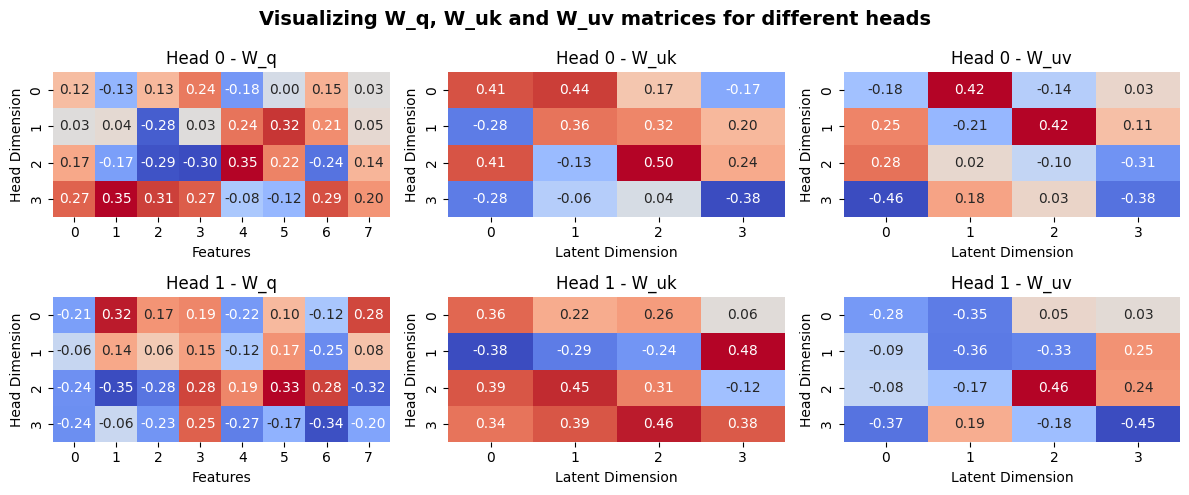

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn

# Define a simplified RopelessMLA class for visualization
class RopelessMLA(nn.Module):
    def __init__(self, d_model=8, n_heads=2, kv_latent_dim=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dh = d_model // n_heads
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_uk = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.W_uv = nn.Linear(kv_latent_dim, d_model, bias=False)

# Create model instance
model = RopelessMLA()

# Extract weights
W_q = model.W_q.weight.detach().numpy()
W_uk = model.W_uk.weight.detach().numpy()
W_uv = model.W_uv.weight.detach().numpy()

# Split per head
n_heads = model.n_heads
dh = model.dh

# Reshape weights per head
W_q_heads = W_q.reshape(n_heads, dh, -1)
W_uk_heads = W_uk.T.reshape(n_heads, dh, -1)
W_uv_heads = W_uv.T.reshape(n_heads, dh, -1)

# Plot heatmaps
fig, axes = plt.subplots(n_heads, 3, figsize=(12, 5))

for h in range(n_heads):
    # W_q heatmap
    sns.heatmap(W_q_heads[h], ax=axes[h, 0], cbar=False, annot=True, fmt=".2f", cmap="coolwarm")
    axes[h, 0].set_title(f"Head {h} - W_q")
    axes[h, 0].set_xlabel("Features")
    axes[h, 0].set_ylabel("Head Dimension")
    
    # W_uk heatmap
    sns.heatmap(W_uk_heads[h], ax=axes[h, 1], cbar=False, annot=True, fmt=".2f", cmap="coolwarm")
    axes[h, 1].set_title(f"Head {h} - W_uk")
    axes[h, 1].set_xlabel("Latent Dimension")
    axes[h, 1].set_ylabel("Head Dimension")
    
    # W_uv heatmap
    sns.heatmap(W_uv_heads[h], ax=axes[h, 2], cbar=False, annot=True, fmt=".2f", cmap="coolwarm")
    axes[h, 2].set_title(f"Head {h} - W_uv")
    axes[h, 2].set_xlabel("Latent Dimension")
    axes[h, 2].set_ylabel("Head Dimension")

plt.suptitle("Visualizing W_q, W_uk and W_uv matrices for different heads", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()